In [1]:
source("~/software/notebook_assist/functions.R")
source("~/software/notebook_assist/packages.R")
library(umap)
# setwd("/projects/CARDIPS/analysis/epigenome_resource/")
theme_bw2 = theme_bw() +
    theme(
        axis.text = element_text(size = 12),
        strip.text = element_text(size = 12),
        axis.title = element_text(size = 12),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 12),
        legend.position = "top"
    )

### Figure SX - Shared and Specific peaks

In [4]:
### ATAC and ChIP Peaks found on Figshare
ipsc_path="path/to/ipsc/atac/peak/bed"
cvpc_path="path/to/cvpc/atac/peak/bed"
ppc_path="path/to/ppc/atac/peak/bed"

ipsc_path="/projects/CARDIPS/analysis/epigenome_resource/analyses/tim/tobias/ipsc_atac/accessible_peaks.bed"
cvpc_path="/projects/CARDIPS/analysis/epigenome_resource/analyses/tim/tobias/cvpc_atac/accessible_peaks.bed"
ppc_path ="/projects/CARDIPS/analysis/epigenome_resource/analyses/tim/tobias/ppc_atac/accessible_peaks.bed"


atac_peaks = rbind(rbind(fread(ipsc_path,sep="\t",data.table=F),fread(cvpc_path,sep="\t",data.table=F)),
                   fread(ppc_path,sep="\t",data.table=F))

atac_peaks$Tissue = ifelse(grepl("ipsc",atac_peaks$V4), "iPSC",
                          ifelse(grepl("cvpc",atac_peaks$V4), "CVPC","PPC"))

atac_peak_path = "sourcedata/all_atac_peaks.bed"
fwrite(atac_peaks %>% arrange(V1,V2,V3),atac_peak_path, sep="\t",row.names=F, col.names=F,quote=F)
bedtools="path/to/bedtools"
bedtools = "/frazer01/software/bedtools-2.25.0/bin/bedtools"

merge_peak_path = "sourcedata/merged_peaks.bed"
cmd = paste(bedtools, "merge -i", atac_peak_path, "-c 4 -o distinct >", merge_peak_path)
system(cmd)

merged_peaks = fread(merge_peak_path, sep="\t",data.table=F)


In [5]:
merged_peaks$Shared = ifelse(grepl(",",merged_peaks$V4), "Shared","Specific")
merged_peaks_long = merged_peaks %>% separate_rows(V4, sep = ",")

In [7]:
merged_peaks_long$Tissue = ifelse(grepl("ipsc",merged_peaks_long$V4), "iPSC",
                          ifelse(grepl("cvpc",merged_peaks_long$V4), "CVPC","PPC"))
table(merged_peaks_long$Tissue,merged_peaks_long$Shared)

      
       Shared Specific
  CVPC 123446    79495
  iPSC 105742    66333
  PPC  127771    65657

`summarise()` has grouped output by 'Tissue'. You can override using the
`.groups` argument.


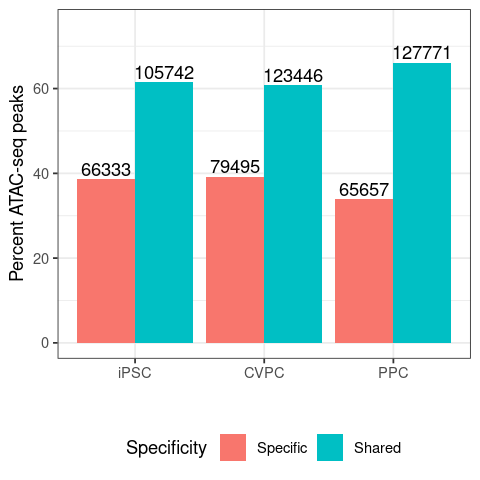

In [5]:
figure_sXa = merged_peaks_long %>%
                  group_by(Tissue, Shared) %>% 
                  summarize(n_peaks = n()) %>%  # Calculate the total number of peaks per tissue
                  ungroup() %>%
                  group_by(Tissue) %>%
                  mutate(total_peaks = sum(n_peaks), Percent = (n_peaks/total_peaks)*100)

figure_sXa$Tissue = factor(figure_sXa$Tissue, levels = c("iPSC","CVPC","PPC"))
figure_sXa$Specificity = factor(figure_sXa$Shared, levels = c("Specific","Shared"))
psize(4,4)


### Figure SX Peak UMAP
#### Make Merged Reference Peaks

In [ ]:
base_dir="/projects/CARDIPS/analysis/epigenome_resource/"
atac.fs = c(paste0(base_dir,"caqtls/iPSC/input/phenotype_info.bed"),
           paste0(base_dir,"caqtls/CVPC/input/phenotype_info.bed"),
           paste0(base_dir,"caqtls/PPC/input/phenotype_info.bed"))
chip.fs = c(paste0(base_dir,"haqtls/iPSC/input/phenotype_info.bed"),
           paste0(base_dir,"haqtls/CVPC/input/phenotype_info.bed"))

atac_peaks = rbindlist(lapply(atac.fs, function(x){return(fread(x,sep="\t") %>% filter(V1 %in% paste0("chr",1:22)))})) %>% 
                    arrange(V1,V2,V3)
chip_peaks = rbindlist(lapply(chip.fs, function(x){return(fread(x,sep="\t") %>% filter(V1 %in% paste0("chr",1:22)))})) %>% 
                    arrange(V1,V2,V3)

# fwrite(atac_peaks, "analyses/tim/merged_umap/peaks/atac.bed",sep="\t",row.names=F,col.names=F,quote=F)
# fwrite(chip_peaks, "analyses/tim/merged_umap/peaks/chip.bed",sep="\t",row.names=F,col.names=F,quote=F)


bedtools_path="/frazer01/software/bedtools-2.25.0/bin/bedtools"

merge_peaks = function(type) {
    in_file = paste0(base_dir,"analyses/tim/merged_umap/peaks/",type,".bed")
    out_file = paste0(base_dir,"analyses/tim/merged_umap/peaks/",type,".merged.bed")
    
    cmd = paste(bedtools_path, "merge -i",in_file,">", out_file)
    message(cmd)
    system(cmd)
    toSAF = fread(out_file,sep="\t",data.table=F) %>% mutate(id = paste(V1,V2,V3,sep="_"), strand = ".") %>% select(id, V1 ,V2, V3,strand)
#     fwrite(toSAF,  paste0(base_dir,"analyses/tim/merged_umap/peaks/",type,".merged.saf"),sep="\t",row.names=F,quote=F,col.names=F)
    
    system(paste("rm", in_file))
    
}

# merge_peaks("atac")
# merge_peaks("chip")

#### Compile counts 

In [ ]:
compile_counts = function(type) {
    count_dirs=list.files(paste0(base_dir,"analyses/tim/merged_umap/counts/",type),full.names=T)
    uuids = gsub("/projects/CARDIPS/analysis/epigenome_resource/analyses/tim/merged_umap/counts/[a-z]+/","",count_dirs)
    fs = list.files(count_dirs,pattern="all_reference_peaks.counts$", full.names=T)

    counts = lapply(fs, function(f){
        ct = fread(f, sep="\t",data.table=F)[,c(1,7)]
        return(ct)
    })
    out = Reduce(function(...) merge(..., all=T), counts)
        return(out)
}
# atac_compiled = compile_counts("atac")
chip_compiled = compile_counts("chip") 

In [ ]:
colnames(chip_compiled) = gsub("/.*","",gsub(".*hg38/","",colnames(chip_compiled)))
head(chip_compiled)

In [102]:
atac_tmm = add_rownames(fread("/projects/CARDIPS/analysis/epigenome_resource/analyses/tim/merged_umap/scripts/atac_tmm.txt",sep="\t",data.table=F))
chip_tmm = add_rownames(fread("/projects/CARDIPS/analysis/epigenome_resource/analyses/tim/merged_umap/scripts/chip_tmm.txt",sep="\t",data.table=F))

In [103]:
atac_meta = fread("~/projects/Resource/SupplementalTables/TableS3_ATACMetadata_v2.txt",sep="\t",data.table=F)[,c("ATAC UUID","Tissue")]
names(atac_meta)[1] = "uuid"
chip_meta = fread("~/projects/Resource/SupplementalTables/TableS4_ChIPMetadata_v2.txt",sep="\t",data.table=F)[,c("ChIP UUID","Tissue")]
names(chip_meta)[1] = "uuid"
atac_meta$Tissue = factor(atac_meta$Tissue, levels = c("iPSC","CVPC","PPC"))
chip_meta$Tissue = factor(chip_meta$Tissue, levels = c("iPSC","CVPC"))

In [104]:
run_umap = function(tmm, meta) {
    tmm$Variance = rowVars(data.matrix(tmm))
    tmm_top = tmm %>% top_n(2000,Variance)
    tmm_top$Variance = NULL
    pca = as.data.frame(prcomp(tmm_top)$rotation)
    umap_out = as.data.frame(umap(pca[,1:6])$layout)
    umap_out$uuid = rownames(umap_out)
    umap_out2 = merge(umap_out, meta)
    return(umap_out2)
}
chip_umap = run_umap(chip_tmm, chip_meta)
atac_umap = run_umap(atac_tmm, atac_meta)

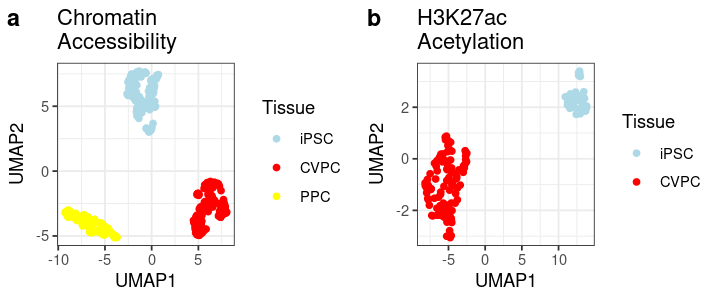

In [124]:
atac_plt = ggplot(atac_umap, aes(V1, V2, color =Tissue )) + theme_bw() + 
                    ggtitle("Chromatin\nAccessibility") + 
                    xlab("UMAP1") + ylab("UMAP2") + geom_point()+ 
                    scale_color_manual(values = c("lightBlue","red","yellow"))
chip_plt = ggplot(chip_umap, aes(V1, V2, color =Tissue )) + theme_bw() + 
                     ggtitle("H3K27ac\nAcetylation") + 
                    xlab("UMAP1") + ylab("UMAP2") + geom_point() + 
                    scale_color_manual(values = c("lightBlue","red"))
psize(2.5,6)
s4_ab = plot_grid(atac_plt,chip_plt, nrow =1 ,labels = c("a","b"))
s4_ab

In [129]:
shared_plot = ggplot(figure_sXa, aes(Tissue, Percent,fill=Specificity)) + 
            theme_bw() + 
            theme(legend.position = "bottom") +
            ylab("Percent\nATAC-seq peaks") + xlab("") +
            ylim(c(0,75)) +
            geom_bar(stat="identity",position="dodge") +
            geom_text(aes(label=n_peaks), position=position_dodge(width=0.9), vjust=-0.25) + 
            guides(fill = guide_legend(title.position = "top"))

s4_c = plot_grid(shared_plot,NULL,labels = c("c",""), rel_widths = c(2,1))
psize(6,6)
png("~/projects/Resource/notebooks/toGitHub/supplementalfigures/figure_s4.png",res=300,units = "in",
   height=6, width=6)
plot_grid(s4_ab,s4_c,nrow=2)
dev.off()

png 
  2

### Figure SX TF Expression

In [66]:
gene_info = fread("/reference/private/Gencode.v44lift38/gene_info.txt",sep="\t",data.table=F)

ipsc_exp_path="path/to/ipsc/expression"
cvpc_exp_path="path/to/cvpc/expression"
ppc_exp_path="path/to/ppc/expression"

ipsc_exp_path="/projects/CARDIPS/analysis/epigenome_resource/eqtls/iPSC/input/phenotype_tpm_matrix.txt"
cvpc_exp_path="/projects/CARDIPS/analysis/epigenome_resource/eqtls/CVPC/input/phenotype_tpm_matrix.txt"
ppc_exp_path="/projects/CARDIPS/analysis/epigenome_resource/eqtls/PPC/input/phenotype_tpm_matrix.txt"

ipsc_exp = fread(ipsc_exp_path,sep="\t",data.table=F)
cvpc_exp = fread(cvpc_exp_path,sep="\t",data.table=F)
ppc_exp  = fread(ppc_exp_path,sep="\t",data.table=F)

In [81]:
exp_tfs = unique(tf_toplot$TF)
exp_tfs = gsub("var.2","",exp_tfs)

genes2plot = gene_info[ gene_info$gene_name %in% exp_tfs , ]

melt_genes = function(exp_mat, tissue) {
    filt_mat = exp_mat[ exp_mat$V1 %in% genes2plot$gene_id, ]
    melt_filt = melt(filt_mat)
    colnames(melt_filt) = c("gene_id","sample_id","TPM")
    melt_filt2 = merge(melt_filt,genes2plot[,c("gene_name","gene_id")])
    melt_filt2$Tissue = tissue
    return(melt_filt2)
}

melted = rbind(rbind(melt_genes(ipsc_exp, "iPSC"),melt_genes(cvpc_exp, "CVPC")),melt_genes(ppc_exp, "PPC"))

Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(filt_mat). In the next version, this warning will become an error.”
Using V1 as id variables

Warning message:
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(filt_mat). In the next version, this warning will become an error.”
Using V1 as id variables

Warn

In [99]:
psize(7,6)
gene_factors = c("NANOG","POU5F1","SOX2",
                "NKX2-5","MEF2C","GATA4",
                "PDX1","HNF1B","NKX6-1",
                "CTCF","E2F4","TGIF2")
melted2 = melted[ melted$gene_name %in% gene_factors, ]
melted2$Gene = factor(melted2$gene_name, levels = gene_factors)
melted2$Tissue = factor(melted2$Tissue, levels = c("iPSC","CVPC","PPC"))
png("supplementalfigures/figure_s5.png",units="in",res=300, height=7,width=6)
ggplot(melted2, aes(Tissue, TPM, group=Tissue)) + theme_bw() + 
            ylab("Expression (TPM)") +
            geom_boxplot() + geom_jitter(size=0.75) + 
            facet_wrap(~Gene, scales='free', nrow=4)
dev.off()

png 
  2